In [13]:
# Step 0: Imports and inline plotting
import cv2
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# For inline display in Jupyter
%matplotlib inline

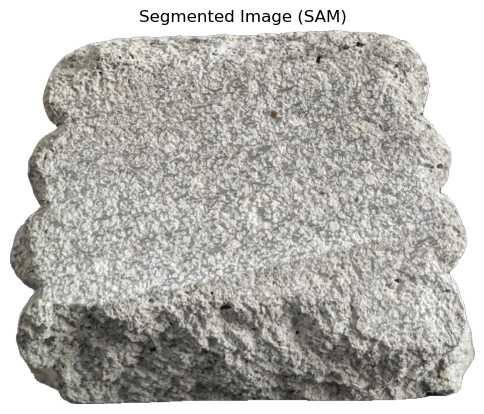

In [ ]:
image_path = 'data/section_sa.png'

img_rgb = cv2.imread(image_path)

img_rgba = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
img_rgba = cv2.cvtColor(img_rgba, cv2.COLOR_BGRA2RGBA)

if img_rgba is None:
    raise ValueError(f"Could not load image from {image_path}")
if img_rgba.shape[2] < 4:
    raise ValueError("The loaded image does not have an alpha channel.")


# Display the original RGBA image
plt.figure(figsize=(6, 6))
plt.imshow(img_rgba)
plt.title("Segmented Image (SAM)")
plt.axis('off')
plt.show()

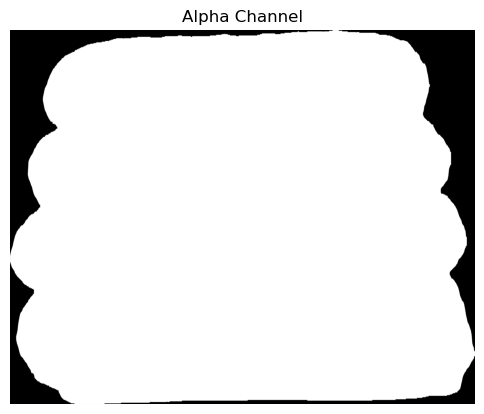

In [15]:
# Alpha channel is the 4th channel in the RGBA image
alpha_channel = img_rgba[:, :, 3]

# Display the alpha channel
plt.figure(figsize=(6, 6))
plt.imshow(alpha_channel, cmap='gray')
plt.title("Alpha Channel")
plt.axis('off')
plt.show()

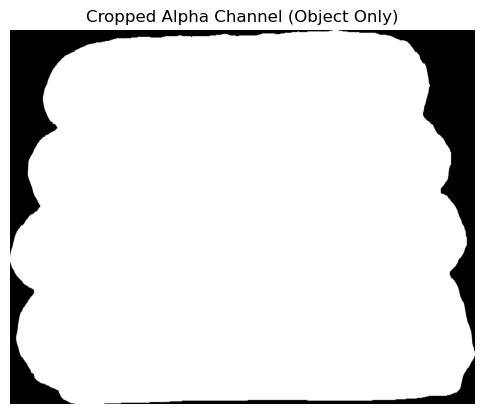

Cropped region size: 2175 rows x 2705 columns


In [16]:
# Find all the non-zero alpha locations
non_zero_coords = np.where(alpha_channel > 0)

if len(non_zero_coords[0]) == 0:
    raise ValueError("No non-transparent pixels found in alpha channel.")

# y-coordinates are non_zero_coords[0], x-coordinates are non_zero_coords[1]
y_min, y_max = np.min(non_zero_coords[0]), np.max(non_zero_coords[0])
x_min, x_max = np.min(non_zero_coords[1]), np.max(non_zero_coords[1])

# We can crop to this bounding box to limit processing to the object
cropped_alpha = alpha_channel[y_min:y_max+1, x_min:x_max+1]

plt.figure(figsize=(6, 6))
plt.imshow(cropped_alpha, cmap='gray')
plt.title("Cropped Alpha Channel (Object Only)")
plt.axis('off')
plt.show()

# Dimensions of the cropped region
height, width = cropped_alpha.shape
print("Cropped region size:", height, "rows x", width, "columns")

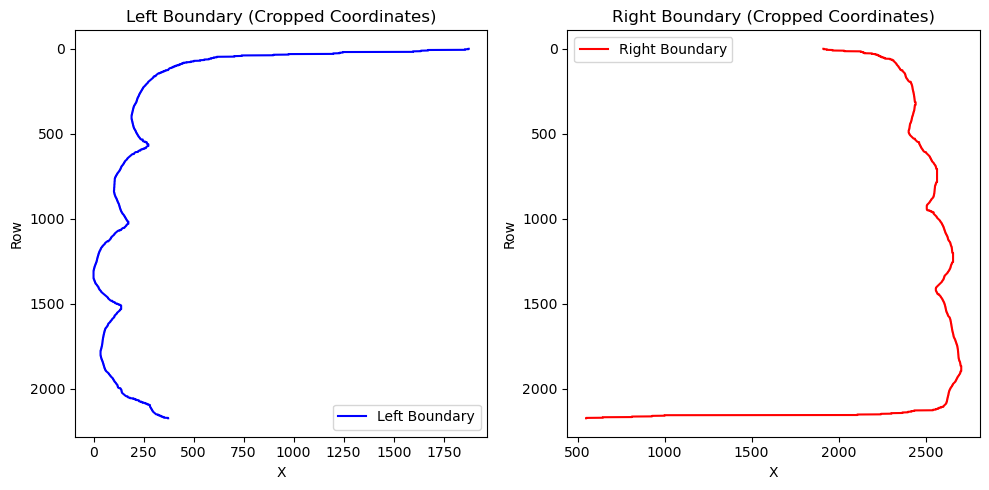

In [30]:
# Initialize arrays to store leftmost and rightmost x-coordinates (within the cropped region)
left_boundary = np.full(height, np.nan)
right_boundary = np.full(height, np.nan)

for row_idx in range(height):
    row_pixels = cropped_alpha[row_idx, :]
    # Find indices where alpha > 0
    filled_indices = np.where(row_pixels > 0)[0]
    if len(filled_indices) > 0:
        left_boundary[row_idx] = filled_indices[0]  # leftmost
        right_boundary[row_idx] = filled_indices[-1]  # rightmost

# For convenience, we might want to add x_min offset back to these boundaries
# if we want absolute coordinates in the original image:
# left_boundary_abs = left_boundary + x_min
# right_boundary_abs = right_boundary + x_min

# Let's visualize the boundary curves (in cropped coordinates)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(left_boundary, range(height), color='blue', label='Left Boundary')
plt.gca().invert_yaxis()
plt.title("Left Boundary (Cropped Coordinates)")
plt.xlabel("X")
plt.ylabel("Row")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(right_boundary, range(height), color='red', label='Right Boundary')
plt.gca().invert_yaxis()
plt.title("Right Boundary (Cropped Coordinates)")
plt.xlabel("X")
plt.ylabel("Row")
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
# Replace NaNs with 0 (or some appropriate value) for peak detection
left_data = np.nan_to_num(left_boundary)
right_data = np.nan_to_num(right_boundary)

# Detect local maxima
peaks_left, _ = find_peaks(left_data, distance=5)   # 'distance' is a parameter to tune
peaks_right, _ = find_peaks(right_data, distance=5)

# Detect local minima (invert the data)
troughs_left, _ = find_peaks(-left_data, distance=5)
troughs_right, _ = find_peaks(-right_data, distance=5)

print("Left boundary maxima (rows):", peaks_left)
print("Left boundary minima (rows):", troughs_left)
print("Right boundary maxima (rows):", peaks_right)
print("Right boundary minima (rows):", troughs_right)

Left boundary maxima (rows): [ 567 1023 1521]
Left boundary minima (rows): [ 402  837 1328 1790]
Right boundary maxima (rows): [ 322  746 1228 1881]
Right boundary minima (rows): [ 487  933 1415]


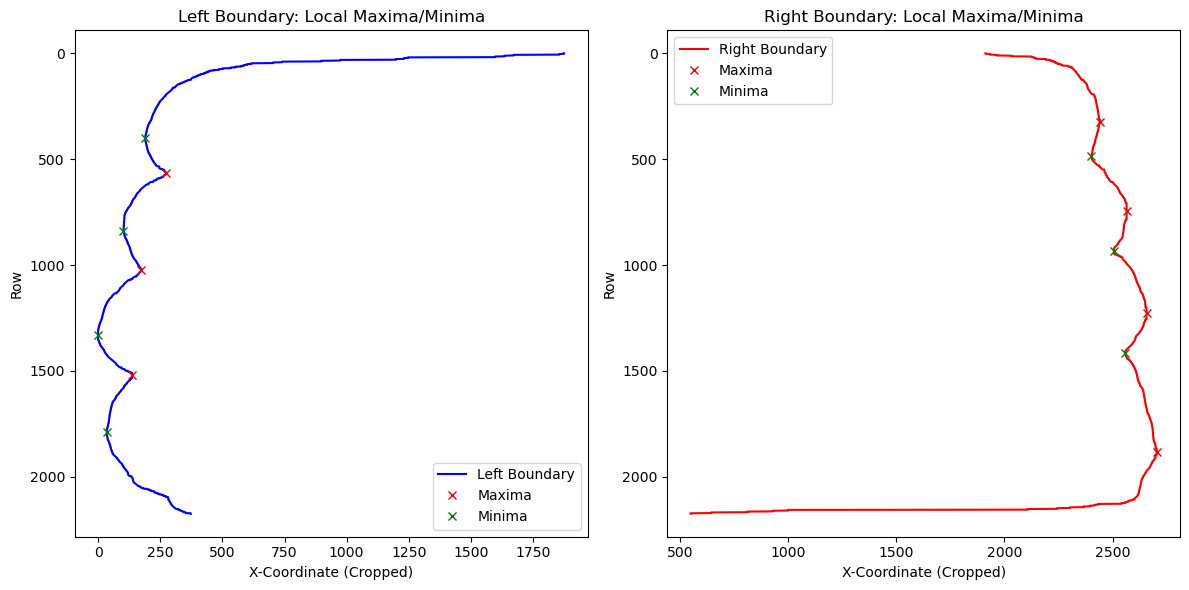

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Left boundary
axes[0].plot(left_data, range(height), color='blue', label='Left Boundary')
axes[0].invert_yaxis()
axes[0].plot(left_data[peaks_left], peaks_left, "rx", label='Maxima')
axes[0].plot(left_data[troughs_left], troughs_left, "gx", label='Minima')
axes[0].set_title("Left Boundary: Local Maxima/Minima")
axes[0].set_xlabel("X-Coordinate (Cropped)")
axes[0].set_ylabel("Row")
axes[0].legend()

# Right boundary
axes[1].plot(right_data, range(height), color='red', label='Right Boundary')
axes[1].invert_yaxis()
axes[1].plot(right_data[peaks_right], peaks_right, "rx", label='Maxima')
axes[1].plot(right_data[troughs_right], troughs_right, "gx", label='Minima')
axes[1].set_title("Right Boundary: Local Maxima/Minima")
axes[1].set_xlabel("X-Coordinate (Cropped)")
axes[1].set_ylabel("Row")
axes[1].legend()

plt.tight_layout()
plt.show()

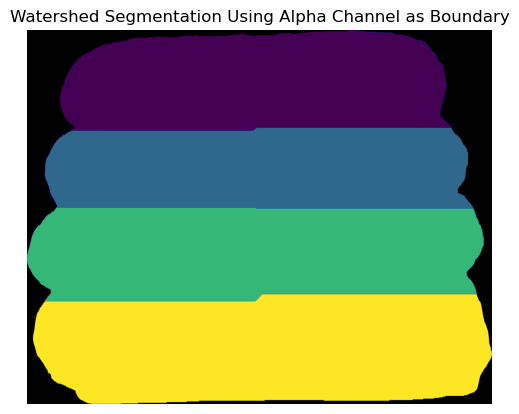

In [ ]:


# # Pair the left minima with the right maxima. We use the minimum number of detections.
# num_pairs = min(len(troughs_left), len(peaks_right))
# seed_points = []

# for i in range(num_pairs):
#     y_left = troughs_left[i]   # row index from left minima
#     y_right = peaks_right[i]   # row index from right maxima
    
#     # Get corresponding x coordinates from the boundaries (convert to int)
#     x_left = int(left_boundary[int(y_left)])
#     x_right = int(right_boundary[int(y_right)])
    
#     # Compute the center point between these two points
#     center_x = int((x_left + x_right) / 2)
#     center_y = int((y_left + y_right) / 2)
#     seed_points.append((center_x, center_y))

# # Prepare the image for watershed using the alpha channel.
# # The alpha channel already delineates the printed object.
# # Convert cropped_alpha (a binary mask) to a 3-channel image.
# img_for_watershed = cv2.cvtColor(cropped_alpha, cv2.COLOR_GRAY2BGR)

# # Optionally smooth the image (if needed) to reduce noise.
# img_for_watershed = cv2.GaussianBlur(img_for_watershed, (3, 3), 0)

# # Create a marker image of the same size as cropped_alpha.
# # Start with zeros everywhere. The background (alpha == 0) remains 0.
# markers = np.zeros(cropped_alpha.shape, dtype=np.int32)

# # Place unique labels at each seed point (labels must be > 0).
# for i, pt in enumerate(seed_points):
#     markers[pt[1], pt[0]] = i + 1  # (Note: indexing is (row, col))

# # Run the watershed algorithm.
# # The watershed will flood the object region defined by the alpha channel.
# cv2.watershed(img_for_watershed, markers)

# # The watershed boundaries are marked with -1 in the markers array.
# watershed_boundaries = (markers == -1)

# # Create an output image for visualization.
# watershed_result = np.zeros_like(img_for_watershed)

# # Color each watershed region using a matplotlib colormap based on the seed order.
# n_regions = len(seed_points)
# cmap = plt.cm.viridis  # Choose any matplotlib colormap you like

# for label in range(1, n_regions + 1):
#     norm_val = (label - 1) / (n_regions - 1) if n_regions > 1 else 0.5
#     rgba = cmap(norm_val)  # rgba in [0, 1]
#     color = tuple(int(255 * c) for c in rgba[:3])
#     watershed_result[markers == label] = color

# # Mark watershed boundaries in red.
# watershed_result[watershed_boundaries] = (0, 0, 255)

# # Ensure that regions outside the printed object (alpha==0) remain black.
# watershed_result[cropped_alpha == 0] = 0

# plt.figure(figsize=(6, 6))
# plt.imshow(watershed_result)
# plt.title("Watershed Segmentation Using Alpha Channel as Boundary")
# plt.axis('off')
# plt.show()

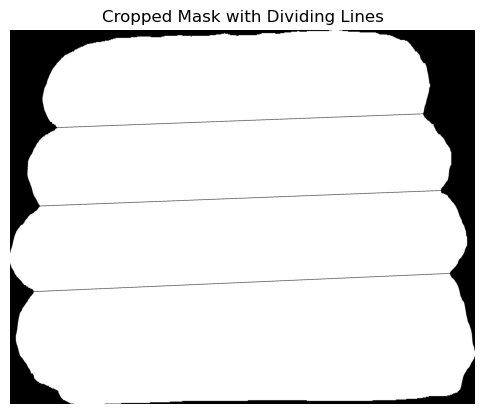

In [ ]:
# Use the detected peaks on the left boundary (maxima) and troughs on the right boundary (minima)
# We assume these arrays (peaks_left and troughs_right) and the boundary arrays (left_boundary and right_boundary)
# are computed in cropped coordinates (from the alpha channel crop).

# For pairing, we take the minimum length of the two arrays.
num_pairs = min(len(peaks_left), len(troughs_right))
dividing_lines = []

for i in range(num_pairs):
    # Get the y coordinate (row index) for the left maximum and right minimum.
    y_left = peaks_left[i]
    y_right = troughs_right[i]
    
    # Get the corresponding x coordinates from the boundary arrays (convert to int)
    x_left = int(left_boundary[y_left])
    x_right = int(right_boundary[y_right])
    
    # Save the pair of points (in (x, y) order) that we will connect.
    dividing_lines.append(((x_left, y_left), (x_right, y_right)))

# Create a copy of the cropped alpha mask as a binary mask (object=255, background=0)
_, mask_binary = cv2.threshold(cropped_alpha, 1, 255, cv2.THRESH_BINARY)
mask_with_lines = mask_binary.copy()

# Draw each dividing line in black (0) on the binary mask.
# A thicker line (e.g. 3 pixels) is used to help ensure the zones become separated.
for line in dividing_lines:
    pt1, pt2 = line
    cv2.line(mask_with_lines, pt1, pt2, color=0, thickness=3)

# Optionally, dilate the lines slightly to guarantee they form a continuous barrier.
kernel = np.ones((3, 3), np.uint8)
mask_with_lines = cv2.dilate(mask_with_lines, kernel, iterations=1)

# Visualize the mask with dividing lines.
plt.figure(figsize=(6, 6))
plt.imshow(mask_with_lines, cmap='gray')
plt.title("Cropped Mask with Dividing Lines")
plt.axis('off')
plt.show()

Number of zones detected (excluding background): 4


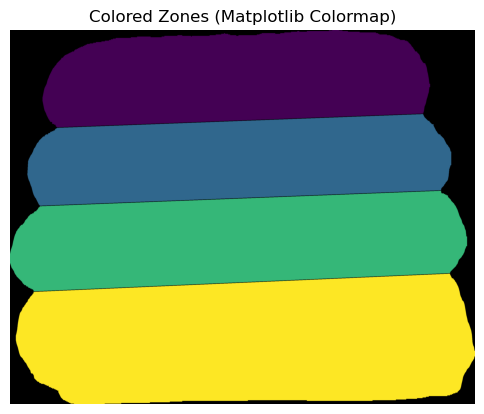

In [21]:
# Run connected components on the mask with dividing lines.
num_labels, labels_im = cv2.connectedComponents(mask_with_lines)
print("Number of zones detected (excluding background):", num_labels - 1)

# For each zone (label > 0), compute the mean y-coordinate to determine its vertical order.
zone_y_positions = {}
for label in range(1, num_labels):
    indices = np.where(labels_im == label)
    if indices[0].size > 0:
        mean_y = np.mean(indices[0])
        zone_y_positions[label] = mean_y

# Sort the zone labels based on the computed mean y (from top to bottom).
sorted_labels = sorted(zone_y_positions, key=lambda l: zone_y_positions[l])
n_zones = len(sorted_labels)

# Choose a matplotlib colormap, e.g. 'viridis'
cmap = plt.cm.viridis

# Build a dictionary mapping each zone label to a color.
# We normalize the order from 0 to 1 based on the sorted order.
zone_colors = {0: (0, 0, 0)}  # keep background black
for i, label in enumerate(sorted_labels):
    norm_val = i / (n_zones - 1) if n_zones > 1 else 0.5
    rgba = cmap(norm_val)  # returns (r, g, b, a) in the [0,1] range
    # Convert to 8-bit RGB (ignore the alpha channel)
    zone_colors[label] = tuple(int(255 * c) for c in rgba[:3])

# Create an output image to visualize the colored zones.
zone_img = np.zeros((mask_with_lines.shape[0], mask_with_lines.shape[1], 3), dtype=np.uint8)
for label, color in zone_colors.items():
    zone_img[labels_im == label] = color

plt.figure(figsize=(6, 6))
plt.imshow(zone_img)
plt.title("Colored Zones (Matplotlib Colormap)")
plt.axis('off')
plt.show()

Rough area (in pixel count) for each zone/layer:
Zone 1: 1059991 pixels
Zone 2: 1066273 pixels
Zone 3: 1248312 pixels
Zone 4: 1746422 pixels


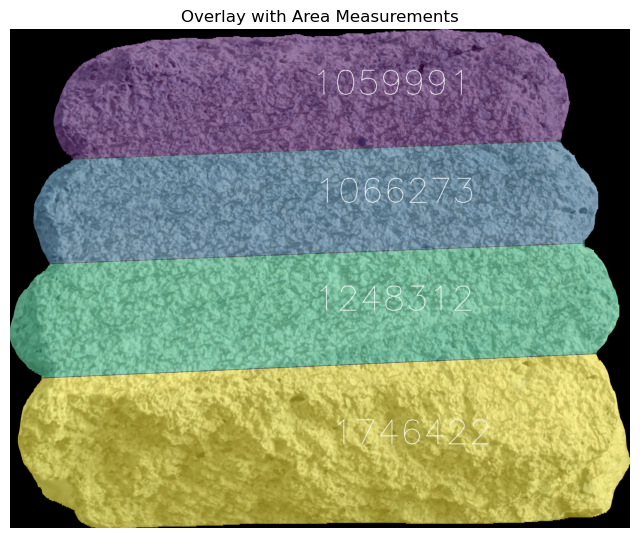

In [25]:
# Step 9: Overlay the Colored Zones on the Original Image

# Create a copy of the original image in RGB (we already have img_rgb from earlier)
original_rgb = img_rgb.copy()

# Create an overlay image that is a copy of the original
overlay = original_rgb.copy()

# Paste the colored zones (zone_img) into the overlay at the position of the cropped region.
# Recall: cropped region coordinates: (x_min, y_min) to (x_max, y_max)
overlay[y_min:y_max+1, x_min:x_max+1] = zone_img

# Blend the overlay with the original image.
# Adjust alpha_overlay (0.0 to 1.0) to change the transparency of the colored zones.
alpha_overlay = 0.5
result = cv2.addWeighted(overlay, alpha_overlay, original_rgb, 1 - alpha_overlay, 0)

# Step 10: Compute Rough Area Measurement for Each Layer

# Compute area for each zone (layer) as the number of pixels in that zone.
zone_areas = {}
for label in sorted_labels:
    area = np.sum(labels_im == label)
    zone_areas[label] = area

print("Rough area (in pixel count) for each zone/layer:")
for label in sorted_labels:
    print(f"Zone {label}: {zone_areas[label]} pixels")

# Optionally, annotate the overlay image with the area measurements.
# We will display the areas at the centroid of each zone.

annotated_overlay = result.copy()

for label in sorted_labels:
    # Get coordinates (row, col) of all pixels belonging to the zone
    coords = np.column_stack(np.where(labels_im == label))
    if coords.size == 0:
        continue
    # Compute centroid in cropped coordinates
    centroid = np.mean(coords, axis=0).astype(int)
    # Map the centroid from cropped to absolute coordinates using x_min and y_min
    absolute_centroid = (centroid[1] + x_min, centroid[0] + y_min)
    # Annotate the overlay with the area value.
    cv2.putText(
        annotated_overlay, 
        f"{zone_areas[label]}", 
        absolute_centroid, 
        cv2.FONT_HERSHEY_SIMPLEX, 
        5, 
        (255, 255, 255), 
        2, 
        cv2.LINE_AA
    )

plt.figure(figsize=(8, 8))
plt.imshow(annotated_overlay)
plt.title("Overlay with Area Measurements")
plt.axis('off')
plt.show()